# 0. Imports

In [28]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import os
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from scipy.interpolate import interp1d

#from moepy import lowess
from scipy.optimize import curve_fit # for power curve fitting
import sys
# appending a path with my modules
sys.path.append(r'W:\PD-Engines\Engine Integration Validation\Department\Data Analytics\Wiktor\Python')
import Helpers

sns.set_theme()

color_dict = {'WTG15' : sns.color_palette()[0], #bluish
              'WTG15 new LEP' : sns.color_palette()[3], # redish
              'WTG15 LEP transition' : sns.color_palette()[2],    #green
              'WTG16' : sns.color_palette()[4]}

In [29]:
from utilities import (
    load_data_2024,
    clean_data,
    fit_logistic_power_curve,
    fit_lowess_power_curve,
    get_uniform_windspeed_distribution,
    logistic,
    initial_filter_over_1dcurve,
    fit_power_curve_poly6,
    fit_power_curve_IEC,
    calculate_filter_1dcurve,
    fit_linear_regression,
    calculate_filter_1dcurve_hp
)

In [30]:
def load_data_2025():
    df_list = []
    for file in Helpers.get_files(r'data\2025', extension='.xlsx'):
        df_temp = pd.read_excel(file, engine='openpyxl')
        df_temp['WTG'] = os.path.basename(file).split('-')[0].strip()
        df_list.append(df_temp)
    return pd.concat(df_list, ignore_index=True)

# 1. Load data

In [4]:
df_raw = load_data_2025()

In [6]:
df_raw

,Sygnatura czasowa,Temp otoczenia (avg) [°C],Kierunek wiatru Główny wiatrowskaz (avg) [°],Prędkość wiatru Główny anemometr (avg) [m/s],Kierunek Gondola (avg) [°],Całkowita produkcja energii czynnej (sum) [Wh],Moc czynna (avg) [W],Bezwzględny kierunek wiatru LaPM (avg) [°],Względny kierunek wiatru Główny wiatrowskaz (avg) [°],Czas pracy (co godzinę) [%],WTG
0,2023-01-01 00:10:00,14.0,220.0,13.3,221.0,444355.0,2709000.0,0.0,-1.0,NaN,WTG12
1,2023-01-01 00:20:00,14.0,222.0,13.1,221.0,395165.0,2344300.0,0.0,1.0,NaN,WTG12
2,2023-01-01 00:30:00,14.0,225.0,12.8,224.0,299918.0,1799400.0,0.0,1.0,NaN,WTG12
3,2023-01-01 00:40:00,14.0,223.0,12.9,227.0,300029.0,1800199.0,0.0,-4.0,NaN,WTG12
4,2023-01-01 00:50:00,15.0,224.0,13.8,223.0,300043.0,1800199.0,0.0,1.0,NaN,WTG12
...,...,...,...,...,...,...,...,...,...,...,...
420718,2025-08-31 23:30:00,19.0,110.0,7.8,108.0,120423.0,722400.0,0.0,1.0,NaN,WTG16
420719,2025-08-31 23:40:00,19.0,111.0,8.1,108.0,126029.0,758200.0,0.0,3.0,NaN,WTG16
420720,2025-08-31 23:50:00,19.0,112.0,8.6,108.0,147286.0,884299.0,0.0,3.0,NaN,WTG16
420721,2025-09-01 00:00:00,19.0,111.0,8.8,108.0,154845.0,929099.0,0.0,2.0,NaN,WTG16


In [7]:
df_raw['Moc czynna (avg) [kW]'] = df_raw['Moc czynna (avg) [W]'] / 1000

## 1.1 Find when exactly LEP was applied

Info from Naviga:
* Blade A 02/07/2025
* Blade B 07/08/2025
* Blade C 08/08/2025

so data from 02/07 - 08/08 should not be used 

In [25]:
df_raw.loc[
    df_raw['Sygnatura czasowa'].between(pd.to_datetime('2025/07/02', dayfirst=True), pd.to_datetime('2025/08/08', dayfirst=True)), 
    'WTG'] = 'WTG15 LEP transition'
df_raw.loc[df_raw['Sygnatura czasowa'] >= pd.to_datetime('2025/08/08'), 'WTG'] = 'WTG15 new LEP'

In [21]:
df_wtg15 = df_raw[df_raw.WTG.str.contains('WTG15')]

In [22]:
df_wtg15[df_wtg15['Sygnatura czasowa'] > pd.to_datetime('2025-07-1')]
df_wtg15 = df_wtg15.sort_values(by=('Sygnatura czasowa'))

In [23]:
# Moc vs data
pio.renderers.default = 'browser'

fig = px.line(
    df_wtg15[df_wtg15['Sygnatura czasowa'] > pd.to_datetime('2025-07-1')].iloc[::10],
    x='Sygnatura czasowa',
    y='Moc czynna (avg) [kW]',
    title='WTG15 – Moc czynna od 25 lipca 2025'
)
fig.update_layout(
    title_font_size=24,
    font=dict(size=18),   # Zwiększenie czcionki w całym wykresie
    xaxis_title_font_size=20,
    yaxis_title_font_size=20,
)
fig.show()

In [18]:
# fig incl wind speed
pio.renderers.default = 'browser'

df_plot = df_wtg15[df_wtg15['Sygnatura czasowa'] > pd.to_datetime('2025-07-01')]

fig = go.Figure()

# ─── Moc ─────────────────────────────────────────────────────────────────────
fig.add_trace(go.Scatter(
    x=df_plot['Sygnatura czasowa'],
    y=df_plot['Moc czynna (avg) [kW]'],
    mode='lines',
    name='Moc [kW]',
    line=dict(color='blue', width=2)
))

# ─── Prędkość wiatru ─────────────────────────────────────────────────────────
fig.add_trace(go.Scatter(
    x=df_plot['Sygnatura czasowa'],
    y=df_plot['Prędkość wiatru Główny anemometr (avg) [m/s]'],
    mode='lines',
    name='Prędkość wiatru [m/s]',
    line=dict(color='orange', width=2),
    yaxis='y2'
))

# ─── Layout ──────────────────────────────────────────────────────────────────
fig.update_layout(
    title='WTG15 – Moc i prędkość wiatru po 2025-07-01',
    font=dict(size=18),
    xaxis_title='Czas',
    yaxis_title='Moc [kW]',

    yaxis2=dict(
        title='Prędkość wiatru [m/s]',
        overlaying='y',
        side='right'
    ),

    hovermode='x unified',    
    hoverlabel=dict(font_size=16),
    height=600
)

fig.show()


# 2. Filter data

Ideally try to download IEC 61400-12-1 - it's a document on general norms for analyzing this kind of data, it has filtering info as well.

## 2.1 Remove negative powers and unrealistic points

Wtf that's not expected, double check energy production? Why max power is now at 3k while previously it was at ~2.5k

In [8]:
df_raw

,Sygnatura czasowa,Temp otoczenia (avg) [°C],Kierunek wiatru Główny wiatrowskaz (avg) [°],Prędkość wiatru Główny anemometr (avg) [m/s],Kierunek Gondola (avg) [°],Całkowita produkcja energii czynnej (sum) [Wh],Moc czynna (avg) [W],Bezwzględny kierunek wiatru LaPM (avg) [°],Względny kierunek wiatru Główny wiatrowskaz (avg) [°],Czas pracy (co godzinę) [%],WTG,Całkowita produkcja energii biernej (sum) [VArh],Moc czynna (avg) [kW]
0,2023-01-01 00:10:00,14.0,220.0,13.3,221.0,444355.0,2709000.0,0.0,-1.0,NaN,WTG12,NaN,2709.000
1,2023-01-01 00:20:00,14.0,222.0,13.1,221.0,395165.0,2344300.0,0.0,1.0,NaN,WTG12,NaN,2344.300
2,2023-01-01 00:30:00,14.0,225.0,12.8,224.0,299918.0,1799400.0,0.0,1.0,NaN,WTG12,NaN,1799.400
3,2023-01-01 00:40:00,14.0,223.0,12.9,227.0,300029.0,1800199.0,0.0,-4.0,NaN,WTG12,NaN,1800.199
4,2023-01-01 00:50:00,15.0,224.0,13.8,223.0,300043.0,1800199.0,0.0,1.0,NaN,WTG12,NaN,1800.199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
460033,2025-11-30 23:30:00,4.0,207.0,8.3,207.0,NaN,1053800.0,0.0,0.0,NaN,WTG16,8165.0,1053.800
460034,2025-11-30 23:40:00,4.0,207.0,8.5,208.0,NaN,1057300.0,0.0,-2.0,NaN,WTG16,8166.0,1057.300
460035,2025-11-30 23:50:00,4.0,204.0,8.3,206.0,NaN,1017900.0,0.0,-2.0,NaN,WTG16,8164.0,1017.900
460036,2025-12-01 00:00:00,4.0,205.0,8.2,203.0,NaN,990000.0,0.0,2.0,NaN,WTG16,8173.0,990.000


Text(0.5, 1.0, 'Initial data filtering zone ')

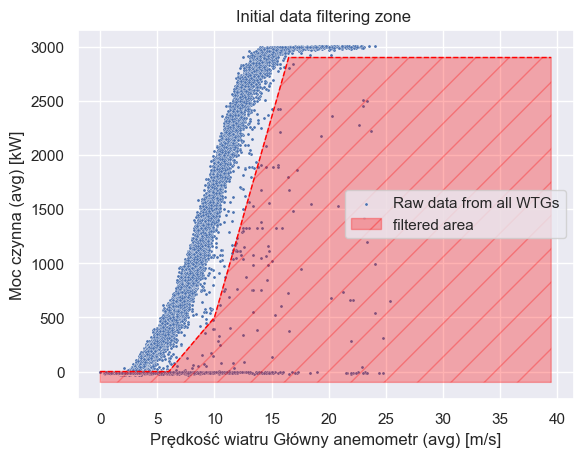

In [9]:
fig, ax = plt.subplots()
filtering_curve = calculate_filter_1dcurve_hp()
sns.scatterplot(data=df_raw.iloc[::10], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', label='Raw data from all WTGs', ax=ax)
sns.lineplot(x=np.arange(0, 40, 0.5), y=filtering_curve(np.arange(0, 40, 0.5)), label='_filtering curve', ax=ax, color='red', linestyle='--', linewidth =1)
ax.fill_between(np.arange(0, 40, 0.5), filtering_curve(np.arange(0, 40, 0.5)), y2= -100, color='red', alpha=0.3, hatch='/', label='filtered area')
plt.legend()
plt.title('Initial data filtering zone ')

In [10]:
print(f'Length before filtering: {len(df_raw)}')
df = initial_filter_over_1dcurve(df_raw, x_col='Prędkość wiatru Główny anemometr (avg) [m/s]', y_col='Moc czynna (avg) [kW]')
print(f'Length after filtering: {len(df)}')

Length before filtering: 460038
Length after filtering: 382369


# 3. Check if we have enough data

In [26]:
df_raw['WTG'].unique()

array(['WTG12', 'WTG15 LEP transition', 'WTG15 new LEP', 'WTG15', 'WTG16'],
      dtype=object)

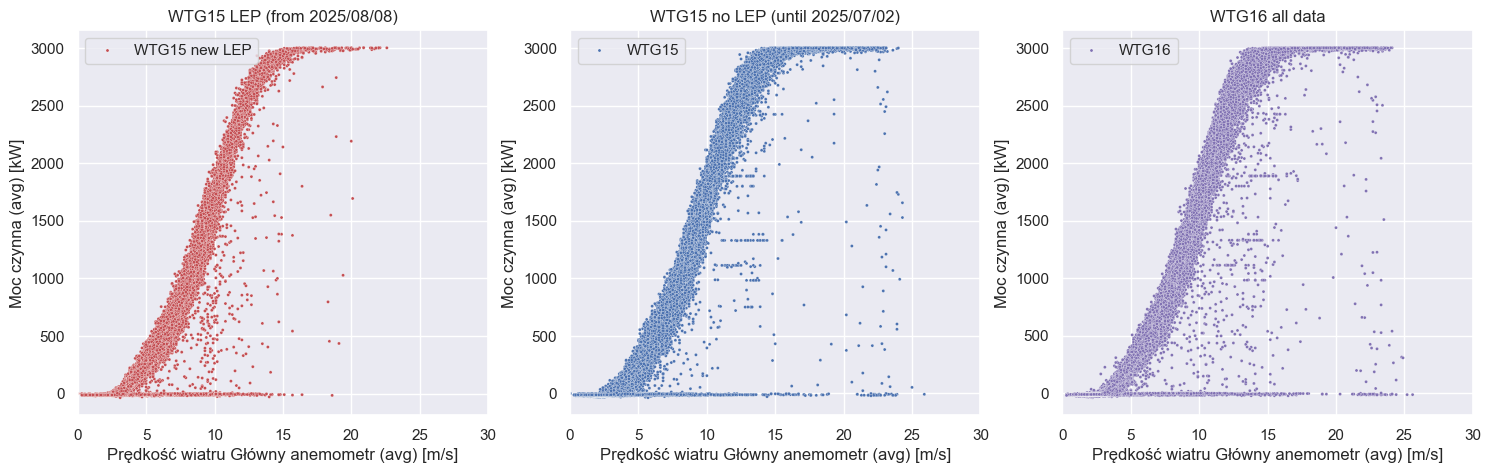

In [31]:
fig, axes = plt.subplots(1,3, figsize=(18, 5))
sns.scatterplot(data=df_raw[df_raw['WTG']=='WTG15 new LEP'], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', hue='WTG', ax=axes[0], palette=color_dict)
sns.scatterplot(data=df_raw[df_raw['WTG']=='WTG15'], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', hue='WTG', ax=axes[1], palette=color_dict)
sns.scatterplot(data=df_raw[df_raw['WTG']=='WTG16'], s=5, x='Prędkość wiatru Główny anemometr (avg) [m/s]', y='Moc czynna (avg) [kW]', hue='WTG', ax=axes[2], palette=color_dict)

axes[0].set_title('WTG15 LEP (from 2025/08/08)')
axes[1].set_title('WTG15 no LEP (until 2025/07/02)')
axes[2].set_title('WTG16 all data')
for ax in axes:
    ax.set_xlim((0,30))
    ax.legend().set_title(None)


In [35]:
from plotly.subplots import make_subplots
pio.renderers.default = 'browser'

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[
        "WTG15 LEP (from 2025/08/08)",
        "WTG15 no LEP (until 2025/07/02)",
        "WTG16 all data"
    ],
    shared_yaxes=True,
    horizontal_spacing=0.05
)

# Helper to add scatter with timestamp in hover
def add_scatter(df, col, name):
    fig.add_trace(
        go.Scatter(
            x=df['Prędkość wiatru Główny anemometr (avg) [m/s]'],
            y=df['Moc czynna (avg) [kW]'],
            mode='markers',
            marker=dict(size=4, color=color_dict[name]),
            name=name,
            customdata=df[['Sygnatura czasowa']],       # add timestamp
            hovertemplate=
                "<b>%{fullData.name}</b><br><br>" +
                "Wiatr: %{x:.2f} m/s<br>" +
                "Moc: %{y:.1f} kW<br>" +
                "Czas: %{customdata[0]}<br>" +
                "<extra></extra>"
        ),
        row=1, col=col
    )

# Data subsets
df1 = df_raw[df_raw['WTG'] == 'WTG15 new LEP']
df2 = df_raw[df_raw['WTG'] == 'WTG15']
df3 = df_raw[df_raw['WTG'] == 'WTG16']

# Add traces
add_scatter(df1, 1, 'WTG15 new LEP')
add_scatter(df2, 2, 'WTG15')
add_scatter(df3, 3, 'WTG16')

# Layout
fig.update_layout(
    height=500,
    width=1400,
    font=dict(size=16),
    legend_title=None,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5
    ),
    hovermode='closest'
)

# Set x-axis limits
fig.update_xaxes(range=[0, 30])

fig.show()


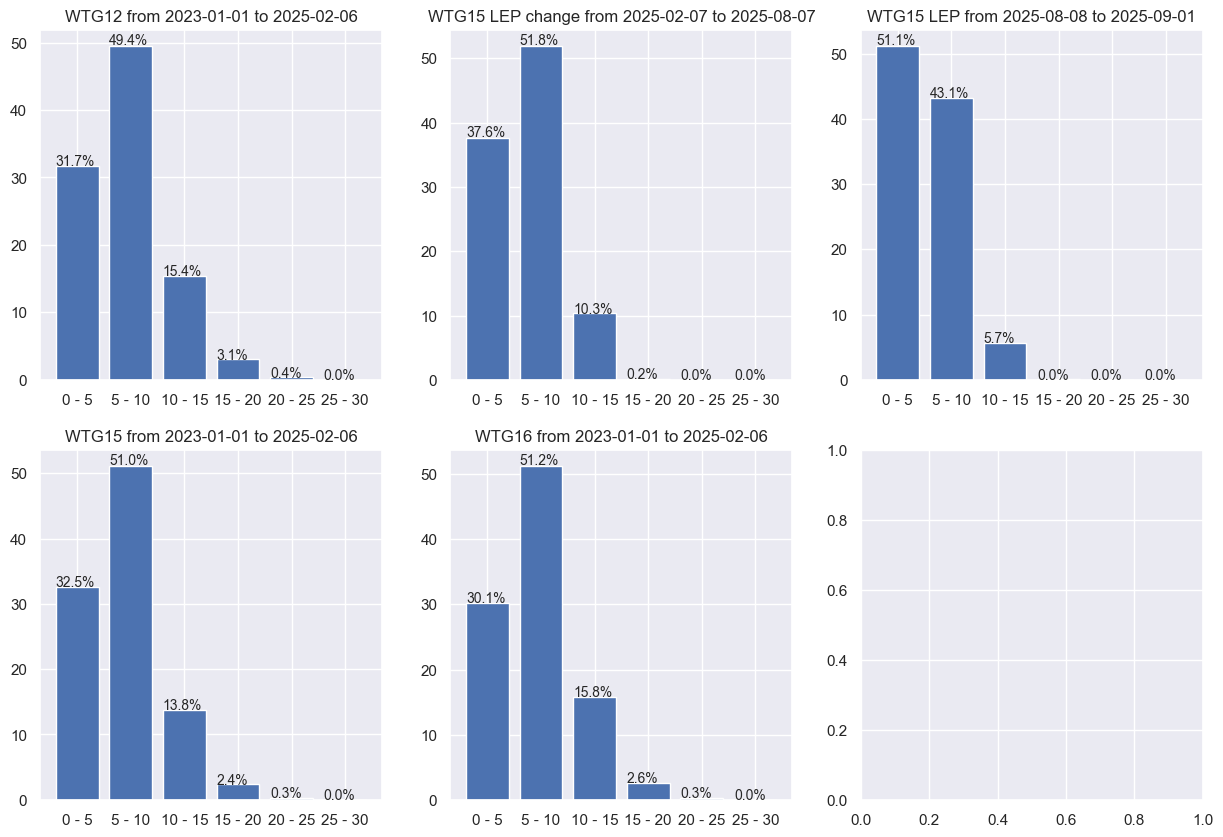

In [ ]:
bins=np.arange(0, 31, 5)
labels = [f'{b} - {b+5}' for b in bins[:-1]]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, wtg in enumerate(df_raw['WTG'].unique()):
    ax = axes.flatten()[i]
    df_temp =  df_raw[df_raw['WTG'] == wtg]
    c, bins = np.histogram(df_temp['Prędkość wiatru Główny anemometr (avg) [m/s]'], bins=bins)
    ax.bar(x=labels, height=c/sum(c)*100)
    Helpers.add_plt_annotations(ax, suffix='%')
    ax.set_title(f"{wtg} from {df_temp['Sygnatura czasowa'].dt.date.min()} to {df_temp['Sygnatura czasowa'].dt.date.max()}")